In [1]:

import igraph as ig
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import Normalize

import numpy as np
import itertools

import RWModelsCPP as rw


In [2]:
def PartSaveRWNet(el, walks, filename):
    '''
    A function to save combinatorial networks and the size of nodes.
    Each combinatorial network we generate is a tree, each line of 
    the file corresponds to a node and contains four values:
    - node :              
        a unique id t for the node, where t is the time 
        step the node was added at
    - parent_node :
        the node that the corresponding node connects to
        it is -1 for the initial node
    - walk_length :
        the number of steps the walker needs to hit parent_node
    - new_sites_visited :
        the number of sites the walker visited before hitting parent_node
    
    Parameters
    ----------
    el : array_like
        the edge list of the combinatorial network in chronological order,
        (e.g., (1,0),(2,0),(3,1),...)
        
    walks :
        a list of walks where a walk is a list of sites visited by the node
    filename :
        the name of the file where we write the network

    Returns
    -------
    None
        
    
    '''
    with open(filename+".csv","wt") as f:
        f.write("node,parent_node,walk_length,new_sites_visited\n")
        a = 0
        for e,walk in zip([(0,-1)]*(len(walks)-len(el))+el,walks):
            f.write(f"{e[0]},{e[1]},{len(walk)},{len(set(walk))-a}\n")
            a = 1
            
    return

### Generate a saturated network

We generate a saturated random physical network using the `rw.Full()` function, which takes three parameters:
- Type of random walk, can be
    - `"LERW"`: loop-erased random walk
    - `"SRW"`: simple random walk
    - `"MSAW"`: myopic or kinetic self-avoiding random walk
    - `"RPC"`: random point cloud or random jumps
    - `"RRAY"`: random ray
- Adjacency list of the substrate graph, can be any graph, we use square lattices.
- Size of initial node

See paper for details.


In [3]:
D = 2 # dimension of grid
L = 20 # linear size of grid
grid = ig.Graph.Lattice([L]*D, circular=False) # generate substrate graph
el, walks = rw.Full("LERW",grid.get_adjlist(),20)

Edge list in chronological order:

In [4]:
el[:5]

[(1, 0), (2, 0), (3, 2), (4, 3), (5, 4)]

Walk trajectories corresponding to physical nodes:

In [5]:
walks[3:5]

[[305, 285, 284, 264, 263, 283, 282, 262, 261, 241, 242, 243, 244, 245],
 [225, 224, 223, 243]]

### Save network

Save details of the network needed for the analysis in the paper.

In [6]:
def PartSaveRWNet(el, walks, filename):
    '''
    A function to save combinatorial networks and the size of nodes.
    Each combinatorial network we generate is a tree, each line of 
    the file corresponds to a node and contains four values:
    - node :              
        a unique id t for the node, where t is the time 
        step the node was added at
    - parent_node :
        the node that the corresponding node connects to
        it is -1 for the initial node
    - walk_length :
        the number of steps the walker needs to hit parent_node
    - new_sites_visited :
        the number of sites the walker visited before hitting parent_node
    
    Parameters
    ----------
    el : array_like
        the edge list of the combinatorial network in chronological order,
        (e.g., (1,0),(2,0),(3,1),...)
        
    walks :
        a list of walks where a walk is a list of sites visited by the node
    filename :
        the name of the file where we write the network

    Returns
    -------
    None
        
    
    '''
    with open(filename+".csv","wt") as f:
        f.write("node,parent_node,walk_length,new_sites_visited\n")
        a = 0
        for e,walk in zip([(0,-1)]*(len(walks)-len(el))+el,walks):
            f.write(f"{e[0]},{e[1]},{len(walk)},{len(set(walk))-a}\n")
            a = 1
            
    return

In [7]:
PartSaveRWNet(el, walks, "network_data.csv")

### Visualize 2D networks

A rather convoluted and under-documented visualization of the network.

In [8]:
def Display2DGrid(L, lines_info, colorby=None, glow=None,
 fmt='-o',filename=None,ax=None,show=True,cmap='jet',cbar_label='',show_colorbar=False,
 lws=None,bgcolor="#ffffff",quad=None, **kwargs):
    """
    A rather convoluted and underdocumented function to draw 2 dimensional physical net
    
    L: linear size of lattice
    lines_info=(lines,line_nodes):
        lines: tentacles given by a list of coordinates
        line_nodes: node that the tentacle belongs to
    colorby:
        if list containing numerical values (e.g. degree), nodes get colored accourding to it
        if None, nodes colors have no specific meaning
    adjacent_sites:
        True: consequtive sites in the tentacle are adjacent in space, takes care of wrap around periodic boundart
        False: non-adjacent in space, useful for the random point cloud tentacle
    **kwarg: all additional attributes get passed on to matplotlib
    """
    plotstyle = {
        'linewidth':  2.,
        'markersize': 8.
    }
    plotstyle.update(kwargs)
    
    lines,line_nodes = lines_info
    N = max(line_nodes)+1
    ''
    #break up lines if they loop around
    new_lines = [[] for line in lines]
    for l, nl in zip(lines,new_lines): 
        nl.append([])
        for point in l:
            nl[-1].append(point)
            

    #transform
    if quad is not None:
        quad1 = np.array([
            [0.,0.],
            [0.,L],
            [L,L],
            [L,0]
        ])

        h, maskg = cv2.findHomography(quad1, quad, cv2.RANSAC)

        
        tr_lines = []
        for segments in new_lines:
            tr_lines.append([])
            for seg in segments:
                tr_lines[-1].append([])
                for c in seg:
                    tr_lines[-1][-1].append(transform_point(h, c))

        new_lines=tr_lines
        
    #plottage
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(8,8))
    else:
        plt.sca(ax)
        fig = plt.gcf()
    ax.axis('off')
        
    if type(colorby) is list and type(colorby[0]) is str:
        colors  = colorby
        colorby = None
    elif colorby is not None:
        norm = Normalize(vmin=min(colorby), vmax=max(colorby))
        cmap=matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    for t, segments in zip(line_nodes[::-1],new_lines[::-1]):
        if colorby is None:
            color = colors[t]
        else:
            color = cmap.to_rgba(colorby[t])
        for line in segments:
            plt.plot(*zip(*line), fmt,color=color,linewidth=lws[t])
            
            if glow[t]:
                n_shades = 20
                diff_linewidth = .5
                alpha_value = 0.5 / n_shades

                for n in range(1, n_shades+1):
                    plt.plot(*zip(*line), fmt,
                         linewidth=lws[t]+(diff_linewidth*n),
                         alpha=alpha_value,
                         color=color)


    plt.tick_params(axis='both',which='both',bottom=False,labelbottom=False,labelleft=False,left=False)
    
    if colorby is not None:
        cmap._A = []
        if show_colorbar:
            cb = fig.colorbar(cmap,label=cbar_label,aspect=12,shrink=.3)
            cb.outline.set_visible(False)
        
    plt.gca().set_aspect(1., adjustable='box')
    plt.gca().set_facecolor(bgcolor)

    if show:
        if filename is None:
            plt.show()
        else:
            plt.savefig(filename)
    
    return


Transform network into a format that the plotting function understands.

In [9]:
pts = np.array(list(itertools.product(range(L),repeat=2)))
lines = [ [pts[nidx] for nidx in walk] for walk in walks]
nids= np.arange(len(walks))

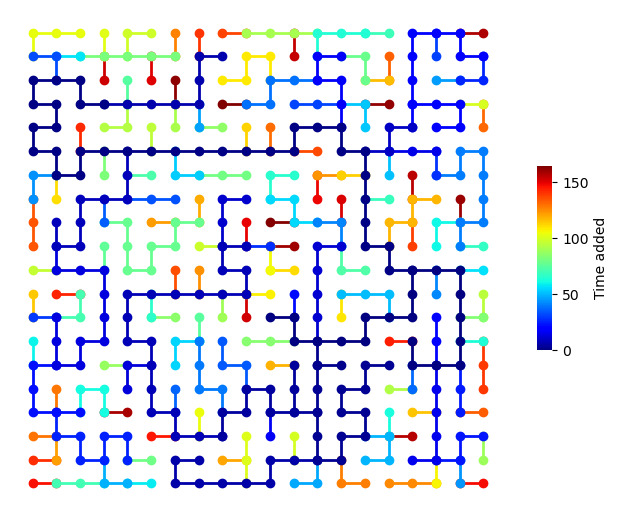

In [10]:
plt.style.use("default")

Display2DGrid(L, 
              (lines,nids), 
              colorby=nids,
              glow = [False for n in nids],
              fmt='-o',
              markersize=3.,
              lws=[2 for n in nids],
              filename=None,
              ax=None,
              show=True,
              cmap='jet',
              cbar_label='Time added',
              show_colorbar=True)


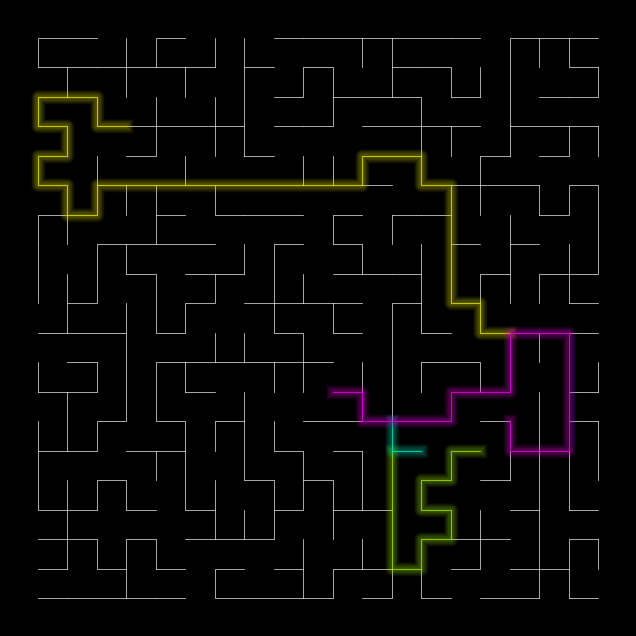

In [11]:
plt.style.use("dark_background")


neon_colors = [
    "#ff00f4",
    "#fdff00",
    "#00ffd2",
    "#b0ff00"
]

c2 = [neon_colors[n] if n<4 else "#eeeeee" for n in nids]


g2 = [True if n<4 else False for n in nids]


Display2DGrid(L, 
              (lines,nids), 
              colorby=c2,
              glow = g2,
              fmt='-',
              markersize=4.,
              lws=[.5 for n in nids],
              filename=None,
              ax=None,
              show=True,
              cmap='jet',
              cbar_label='',
              show_colorbar=False)


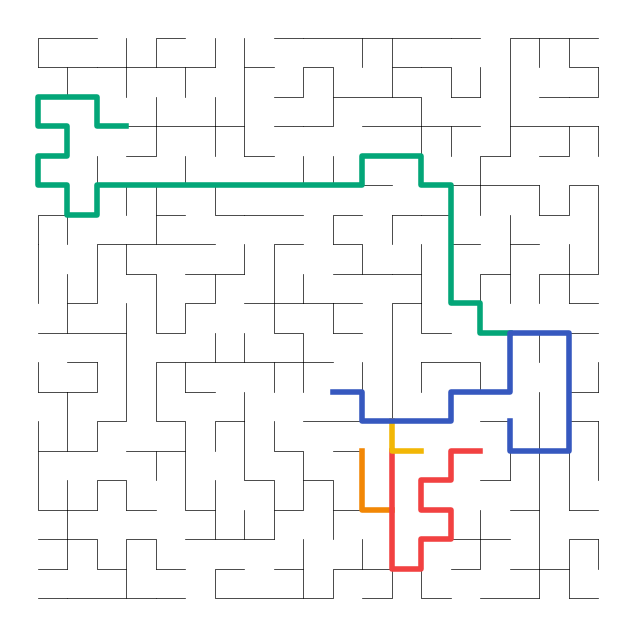

In [12]:
plt.style.use("default")

colors = [
    "#3658BF",
    "#03A678",
    "#F2B705",
    "#F24141",
    "#F28705"
]

c2 = [colors[n] if n<5 else "#000000" for n in nids]

lws2 = [4 if n<5 else .5 for n in nids]

g2 = [False for n in nids]

Display2DGrid(L, 
              (lines,nids), 
              colorby=c2,
              glow = g2,
              fmt='-',
              markersize=4.,
              lws=lws2,
              filename=None,
              ax=None,
              show=True,
              cmap='jet',
              cbar_label='',
              show_colorbar=False)